<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## Problem Statement

We are part of the marketing team for a tv/movie production company. Our company is interested to sign a contract with either Netflix or Disney+ to stream our shows on their platform. Before we make our decisions, we would like to see which platform suits our tv/movie genre the best. To get the sentiments of the users of the platform, we dive into their subreddit community to extract what the community have to say about these platforms. 

We will make use of natural language processing and classification models to classify reddit posts into either netflix or disneyplus. This will allow us to make use of the review of our tv/movies and run it through the classification model to see which platform is a better fit for our tv/movie. 

### Contents:
- [Data Scraping from Reddit and Data cleaning](#Data-Scraping-from-Reddit-and-Data-cleaning)
- [Data Import & Exploratory Data Analysis](#Data-Import-and-Exploratory-Data-Analysis)
- [Natural Language Processing](#Natural-Language-Processing)
- [Modelling](#Modelling)
- [Evaluation](#Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import warnings
warnings.filterwarnings("ignore")

## Data Scraping from Reddit and Data cleaning

### Defining functions to scrape the subreddits

In [ ]:
# Define the base urls for submissions/comments from the reddit api
baseurl = 'https://api.pushshift.io/reddit/search/submission'

In [ ]:
# Define a function to get new parameters for the preceding 250 posts
def get_params(base_df, subreddit):
    params = {
        'subreddit': subreddit, 
        'size': 250, 
        'before': base_df.loc[(base_df.shape[0] - 1), 'created_utc'] 
    }
    return params

In [ ]:
# Define a function that returns a list of dictionaries for the content of each post
def get_posts(params, baseurl='https://api.pushshift.io/reddit/search/submission'):
    res = requests.get(baseurl, params)
    if res.status_code != 200:
        return f'Error! Status code: {res.status_code}'
    else:
        data = res.json()
        posts = data['data']
    return posts

In [ ]:
# Define a function to turn the list of posts into a DataFrame
def create_new_df(posts):
    df = pd.DataFrame(posts)[['subreddit', 'selftext', 'title','created_utc']]
    # Returns posts that have words
    df2 = df[df['selftext'].notnull()]
    df2['post_length'] = df2['selftext'].apply(lambda x: len(x))
    # Returns posts that have at least 30 words
    df3 = df2[df2['post_length'] >= 30]
    df3.reset_index(drop = True, inplace = True)
    return df3

In [ ]:
# Define a function to update the base DataFrame with the 250 succeeding posts
def update_df(base_df, subreddit):
    params = get_params(base_df, subreddit)
    posts = get_posts(params)
    df2 = create_new_df(posts)
    updated = pd.concat([base_df, df2], axis=0, ignore_index=True, sort=True)
    return updated

### Scraping the DisneyPlus subreddit

In [ ]:
# Set up url parameters for the first pull from the DisneyPlus subreddit (max 250 posts)
params_disney = {
    'subreddit': 'DisneyPlus', 
    'size': 250
}

In [ ]:
# Get a list of posts
posts_disney = get_posts(params_disney)

In [ ]:
# Create a dataframe from the posts
df_disney = create_new_df(posts_disney)

In [ ]:
# Look at the shape (rows, columns)
df_disney.shape

In [ ]:
df_disney.head()

In [ ]:
# Continue scraping till we get at least 10,000 posts, with each post consisting of at least 30 words
while df_disney.shape[0] < 10_000:
    df_disney = update_df(df_disney, 'DisneyPlus')
df_disney.shape

In [ ]:
df_disney.head()

In [ ]:
# Export the file into a csv
df_disney.to_csv('../dataset/reddit_disneyplus.csv', index = False)

### Scraping the Netflix Subreddit

In [ ]:
# Set up url parameters for the first pull from the DisneyPlus subreddit (max 250 posts)
params_netflix = {
    'subreddit': 'netflix', 
    'size': 250
}

# Get a list of posts
posts_netflix = get_posts(params_netflix)

# Create a dataframe from the posts
df_netflix = create_new_df(posts_netflix)

# Look at the shape (rows, columns)
df_netflix.shape

In [ ]:
df_netflix.head()

In [ ]:
# Continue scraping till we get at least 10,000 posts, with each post consisting of at least 30 words
while df_netflix.shape[0] < 10_000:
    df_netflix = update_df(df_netflix, 'netflix')
df_netflix.shape

In [ ]:
df_netflix.head()

In [ ]:
# Export the file into a csv
df_netflix.to_csv('../dataset/reddit_netflix.csv', index = False)

The scraped datasets are now saved in: 

> 1. [`reddit_disneyplus.csv`](../dataset/reddit_disneyplus.csv)
> 2. [`reddit_netflix.csv`](../dataset/reddit_netflix.csv)

The data is as of 5 Nov ~2pm.

## Data Import and Exploratory Data Analysis

In [139]:
df_disney = pd.read_csv('../dataset/reddit_disneyplus.csv')

In [140]:
df_netflix = pd.read_csv('../dataset/reddit_netflix.csv')

There are posts with the exact same text in the subreddits. They may be from the same author who are trying to get their point across repeatly. We will remove them from the dataset.

In [141]:
df_disney = df_disney[~df_disney.duplicated(subset=['selftext'])]

In [142]:
df_netflix = df_netflix[~df_netflix.duplicated(subset=['selftext'])]

In [143]:
df_disney.shape, df_netflix.shape

((9886, 5), (10040, 5))

In [144]:
# Keep the first 9,800 posts for both subreddits for the analysis and classification

df_disney = df_disney[:9800]
df_netflix = df_netflix[:9800]

In [145]:
df_disney.shape, df_netflix.shape

((9800, 5), (9800, 5))

In [146]:
combdf = df_disney.append(df_netflix)
combdf.reset_index(drop = True, inplace = True)

In [147]:
combdf.shape

(19600, 5)

In [148]:
combdf.drop('created_utc', axis = 1, inplace = True)

In [149]:
combdf['title_length'] = combdf['title'].apply(lambda x: len(x))

In [150]:
combdf.head()

,post_length,selftext,subreddit,title,title_length
0,75,Honestly pretty upset that they removed the do...,DisneyPlus,Dog whisperer,13
1,545,So I went into cars on the road thinking it wa...,DisneyPlus,My thoughts on cars on the road,31
2,227,What is your favourite full-length Walt Disney...,DisneyPlus,What is your favourite full-length Walt Disney...,85
3,164,Thought I'd watch it after many years of not s...,DisneyPlus,Did they change the voice actor for buck 'ace'...,71
4,105,Does anyone know when it will return since the...,DisneyPlus,Avatar on Disney+?,18


In [151]:
combdf['subreddit'] = [1 if x == 'netflix' else 0 for x in combdf['subreddit']]

In [152]:
combdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19600 entries, 0 to 19599
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   post_length   19600 non-null  int64 
 1   selftext      19600 non-null  object
 2   subreddit     19600 non-null  int64 
 3   title         19600 non-null  object
 4   title_length  19600 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 765.8+ KB


### Data Dictionary

|Feature|Type|Description|
|:--|:--|:--|
|post_length|int|Length of the post in the subreddit| 
|selftext|object|The texts of the post in the subreddit| 
|subreddit|object|Which subreddit the post was posted in. 0 = DisneyPlus and 1 = Netflix| 
|title|object|The title of the post in the subreddit| 
|title_length|object|Length of the title in the subreddit| 


### Exploratory Data Analysis

<AxesSubplot:xlabel='post_length', ylabel='Count'>

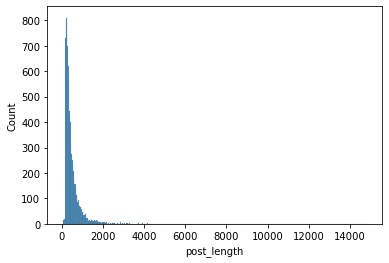

In [153]:
sns.histplot(x = 'post_length', data = combdf[combdf['subreddit'] == 1])

<AxesSubplot:xlabel='post_length', ylabel='Count'>

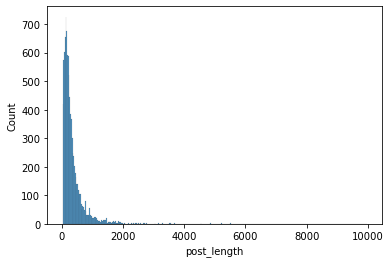

In [154]:
sns.histplot(x = 'post_length', data = combdf[combdf['subreddit'] == 0])

Both graphs are right-skewed, which means that both subreddits have more posts that are fewer in word count.

<AxesSubplot:xlabel='title_length', ylabel='post_length'>

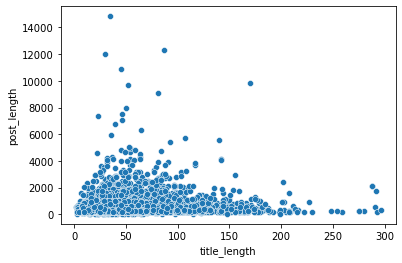

In [158]:
sns.scatterplot(data=combdf[combdf['subreddit'] == 1], x="title_length", y="post_length")

<AxesSubplot:xlabel='title_length', ylabel='post_length'>

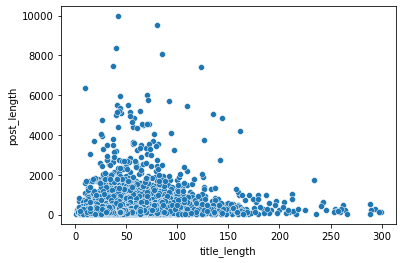

In [159]:
sns.scatterplot(data=combdf[combdf['subreddit'] == 0], x="title_length", y="post_length")

There seems to be no correlation between the length of the title and the length of the post

## Natural Language Processing

In [17]:
# import nltk
# nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re

In [18]:
combdf.head()

,post_length,selftext,subreddit,title
0,75,Honestly pretty upset that they removed the do...,0,Dog whisperer
1,545,So I went into cars on the road thinking it wa...,0,My thoughts on cars on the road
2,227,What is your favourite full-length Walt Disney...,0,What is your favourite full-length Walt Disney...
3,164,Thought I'd watch it after many years of not s...,0,Did they change the voice actor for buck 'ace'...
4,105,Does anyone know when it will return since the...,0,Avatar on Disney+?


In [19]:
combdf.dtypes

post_length     int64
selftext       object
subreddit       int64
title          object
dtype: object

In [20]:
def tokenize_data(row):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(row.lower())

In [21]:
combdf['tokenized_selftext'] = combdf['selftext'].map(tokenize_data)

In [22]:
combdf.head()

,post_length,selftext,subreddit,title,tokenized_selftext
0,75,Honestly pretty upset that they removed the do...,0,Dog whisperer,"[honestly, pretty, upset, that, they, removed,..."
1,545,So I went into cars on the road thinking it wa...,0,My thoughts on cars on the road,"[so, i, went, into, cars, on, the, road, think..."
2,227,What is your favourite full-length Walt Disney...,0,What is your favourite full-length Walt Disney...,"[what, is, your, favourite, full, length, walt..."
3,164,Thought I'd watch it after many years of not s...,0,Did they change the voice actor for buck 'ace'...,"[thought, i, d, watch, it, after, many, years,..."
4,105,Does anyone know when it will return since the...,0,Avatar on Disney+?,"[does, anyone, know, when, it, will, return, s..."


In [23]:
def lemmatize_data(row):
    word = ''
    lemmatizer = WordNetLemmatizer()
    for i in row:
        lemmatizer.lemmatize(i)
        word = word + i + ' '
    word = word.strip()
    return word

In [24]:
combdf['lemmatized_selftext'] = combdf['tokenized_selftext'].map(lemmatize_data)

In [25]:
combdf.head()

,post_length,selftext,subreddit,title,tokenized_selftext,lemmatized_selftext
0,75,Honestly pretty upset that they removed the do...,0,Dog whisperer,"[honestly, pretty, upset, that, they, removed,...",honestly pretty upset that they removed the do...
1,545,So I went into cars on the road thinking it wa...,0,My thoughts on cars on the road,"[so, i, went, into, cars, on, the, road, think...",so i went into cars on the road thinking it wa...
2,227,What is your favourite full-length Walt Disney...,0,What is your favourite full-length Walt Disney...,"[what, is, your, favourite, full, length, walt...",what is your favourite full length walt disney...
3,164,Thought I'd watch it after many years of not s...,0,Did they change the voice actor for buck 'ace'...,"[thought, i, d, watch, it, after, many, years,...",thought i d watch it after many years of not s...
4,105,Does anyone know when it will return since the...,0,Avatar on Disney+?,"[does, anyone, know, when, it, will, return, s...",does anyone know when it will return since the...


In [26]:
def stemming_data(row):
    word = ''
    p_stemmer = PorterStemmer()
    for i in row:
        p_stemmer.stem(i)
        word = word + i + ' '
    word = word.strip()
    return word

In [27]:
combdf['stemming_selftext'] = combdf['tokenized_selftext'].map(stemming_data)

In [28]:
combdf.head()

,post_length,selftext,subreddit,title,tokenized_selftext,lemmatized_selftext,stemming_selftext
0,75,Honestly pretty upset that they removed the do...,0,Dog whisperer,"[honestly, pretty, upset, that, they, removed,...",honestly pretty upset that they removed the do...,honestly pretty upset that they removed the do...
1,545,So I went into cars on the road thinking it wa...,0,My thoughts on cars on the road,"[so, i, went, into, cars, on, the, road, think...",so i went into cars on the road thinking it wa...,so i went into cars on the road thinking it wa...
2,227,What is your favourite full-length Walt Disney...,0,What is your favourite full-length Walt Disney...,"[what, is, your, favourite, full, length, walt...",what is your favourite full length walt disney...,what is your favourite full length walt disney...
3,164,Thought I'd watch it after many years of not s...,0,Did they change the voice actor for buck 'ace'...,"[thought, i, d, watch, it, after, many, years,...",thought i d watch it after many years of not s...,thought i d watch it after many years of not s...
4,105,Does anyone know when it will return since the...,0,Avatar on Disney+?,"[does, anyone, know, when, it, will, return, s...",does anyone know when it will return since the...,does anyone know when it will return since the...


## Modelling

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score

In [30]:
combdf['subreddit'].value_counts(normalize = True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

Since there are equal number of posts belonging to both subreddits, our baseline model has an accuracy score of 50%. We will try out different models and evaluate them against the baseline model.

### Model 1a - Using selftext for Random Forest algorithm

In [31]:
X1 = combdf['selftext']
y1 = combdf['subreddit']

# Split data into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

##### (i) TF-IDF Vectorizer

In [32]:
pipeline1ai = Pipeline([
           ('vect', TfidfVectorizer()),
           ('rf', RandomForestClassifier()),
])

In [33]:
pipeline1ai.get_params()

{'memory': None,
 'steps': [('vect', TfidfVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'vect': TfidfVectorizer(),
 'rf': RandomForestClassifier(),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.float64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__norm': 'l2',
 'vect__preprocessor': None,
 'vect__smooth_idf': True,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__sublinear_tf': False,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__use_idf': True,
 'vect__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 '

In [34]:
parameters1ai = [{
     'vect__max_features': [5_000, 10_000],
     'vect__stop_words': [None, 'english'],
     'vect__ngram_range': [(1,1), (1,2)],
     'rf__max_depth': [5,7],
     'rf__min_samples_split': [2,3]
}]

grid_search_1ai = GridSearchCV(pipeline1ai, parameters1ai, cv=3, verbose = 1)

In [35]:
grid_search_1ai.fit(X1_train, y1_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid=[{'rf__max_depth': [5, 7],
                          'rf__min_samples_split': [2, 3],
                          'vect__max_features': [5000, 10000],
                          'vect__ngram_range': [(1, 1), (1, 2)],
                          'vect__stop_words': [None, 'english']}],
             verbose=1)

In [36]:
grid_search_1ai.best_params_

{'rf__max_depth': 7,
 'rf__min_samples_split': 2,
 'vect__max_features': 5000,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': 'english'}

In [37]:
train_1ai = grid_search_1ai.score(X1_train, y1_train)
train_1ai

0.860969387755102

In [38]:
test_1ai = grid_search_1ai.score(X1_test, y1_test)
test_1ai

0.8528061224489796

Comparing the training and testing score, the accuracy scores are quite similar. There are no signs of overfitting.

In [39]:
# Get predictions
preds_tvec1ai = grid_search_1ai.predict(X1_test)

# F1 score
f1_1ai = f1_score(y1_test,preds_tvec1ai)
f1_1ai

0.8626517495834325

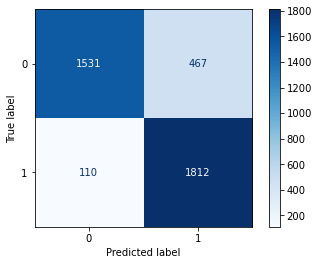

In [40]:
# Save confusion matrix values
tn1ai, fp1ai, fn1ai, tp1ai = confusion_matrix(y1_test, preds_tvec1ai).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_1ai, X1_test, y1_test, cmap='Blues', values_format='d');

##### (ii) Count Vectorizer

In [41]:
pipeline1aii = Pipeline([
           ('cvec', CountVectorizer()),
           ('rf', RandomForestClassifier()),
])

parameters1aii = [{
    'cvec__min_df': [0.05, 0.1],
    'cvec__max_df': [.9, .95],
    'cvec__max_features': [5_000, 10_000],
    'cvec__ngram_range': ((1, 1), (1, 2)),   
    'cvec__stop_words': [None, 'english'],
    'rf__max_depth': [5,7],
    'rf__min_samples_split': [2,3]
}]

grid_search_1aii = GridSearchCV(pipeline1aii, parameters1aii, cv=3, verbose = 1)

In [42]:
grid_search_1aii.fit(X1_train, y1_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid=[{'cvec__max_df': [0.9, 0.95],
                          'cvec__max_features': [5000, 10000],
                          'cvec__min_df': [0.05, 0.1],
                          'cvec__ngram_range': ((1, 1), (1, 2)),
                          'cvec__stop_words': [None, 'english'],
                          'rf__max_depth': [5, 7],
                          'rf__min_samples_split': [2, 3]}],
             verbose=1)

In [43]:
grid_search_1aii.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 10000,
 'cvec__min_df': 0.05,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'rf__max_depth': 7,
 'rf__min_samples_split': 2}

In [44]:
train_1aii = grid_search_1aii.score(X1_train, y1_train)
train_1aii

0.8577168367346939

In [45]:
test_1aii = grid_search_1aii.score(X1_test, y1_test)
test_1aii

0.8426020408163265

Comparing the training and testing score, the accuracy scores are quite similar. There are no signs of overfitting.

In [46]:
# Get predictions
preds_tvec1aii = grid_search_1aii.predict(X1_test)

# F1 score
f1_1aii = f1_score(y1_test,preds_tvec1aii)
f1_1aii

0.8381002361584886

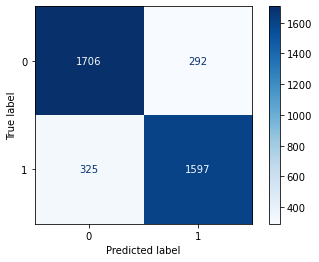

In [47]:
# Save confusion matrix values
tn1aii, fp1aii, fn1aii, tp1aii = confusion_matrix(y1_test, preds_tvec1aii).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_1aii, X1_test, y1_test, cmap='Blues', values_format='d');

### Model 1b - Using selftext for Logistic Regression

##### (i) TF-IDF Vectorizer

In [48]:
pipeline1bi = Pipeline([
           ('vect', TfidfVectorizer()),
           ('lr', LogisticRegression()),
])

In [49]:
pipeline1bi.get_params()

{'memory': None,
 'steps': [('vect', TfidfVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'vect': TfidfVectorizer(),
 'lr': LogisticRegression(),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.float64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__norm': 'l2',
 'vect__preprocessor': None,
 'vect__smooth_idf': True,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__sublinear_tf': False,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__use_idf': True,
 'vect__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state

In [50]:
parameters1bi = [{
    'vect__max_features': [5_000, 10_000],
    'vect__stop_words': [None, 'english'],
    'vect__ngram_range': [(1,1), (1,2)],
    'lr__C': [10,1,0.1],
    'lr__penalty': ['l2','l1']
}]

grid_search_1bi = GridSearchCV(pipeline1bi, parameters1bi, cv=3, verbose = 1)

In [51]:
grid_search_1bi.fit(X1_train, y1_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid=[{'lr__C': [10, 1, 0.1], 'lr__penalty': ['l2', 'l1'],
                          'vect__max_features': [5000, 10000],
                          'vect__ngram_range': [(1, 1), (1, 2)],
                          'vect__stop_words': [None, 'english']}],
             verbose=1)

In [52]:
grid_search_1bi.best_params_

{'lr__C': 1,
 'lr__penalty': 'l2',
 'vect__max_features': 10000,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english'}

In [53]:
train_1bi = grid_search_1bi.score(X1_train, y1_train)
train_1bi

0.9430484693877551

In [54]:
test_1bi = grid_search_1bi.score(X1_test, y1_test)
test_1bi

0.8992346938775511

Even though the training score is quite high, but when comparing the training and testing score we can see that the model is overfitted.

In [55]:
# Get predictions
preds_tvec1bi = grid_search_1bi.predict(X1_test)

# F1 score
f1_1bi = f1_score(y1_test,preds_tvec1bi)
f1_1bi

0.8991575185090631

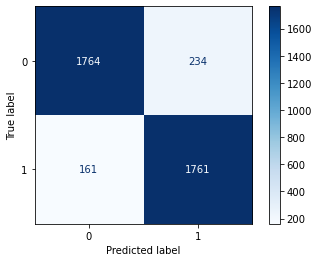

In [56]:
# Save confusion matrix values
tn1bi, fp1bi, fn1bi, tp1bi = confusion_matrix(y1_test, preds_tvec1bi).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_1bi, X1_test, y1_test, cmap='Blues', values_format='d');

##### (ii) CountVectorizer

In [57]:
pipeline1bii = Pipeline([
           ('cvec', CountVectorizer()),
           ('lr', LogisticRegression()),
])

parameters1bii = [{
    'cvec__min_df': [0.05, 0.1],
    'cvec__max_df': [.9, .95],
    'cvec__max_features': [5_000, 10_000],
    'cvec__ngram_range': ((1, 1), (1, 2)),   
    'cvec__stop_words': [None, 'english'],
    'lr__C': [10,1,0.1],
    'lr__penalty': ['l2','l1']
}]

grid_search_1bii = GridSearchCV(pipeline1bii, parameters1bii, cv=3, verbose = 1)

In [58]:
grid_search_1bii.fit(X1_train, y1_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid=[{'cvec__max_df': [0.9, 0.95],
                          'cvec__max_features': [5000, 10000],
                          'cvec__min_df': [0.05, 0.1],
                          'cvec__ngram_range': ((1, 1), (1, 2)),
                          'cvec__stop_words': [None, 'english'],
                          'lr__C': [10, 1, 0.1], 'lr__penalty': ['l2', 'l1']}],
             verbose=1)

In [59]:
grid_search_1bii.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 0.05,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'lr__C': 0.1,
 'lr__penalty': 'l2'}

In [60]:
train_1bii = grid_search_1bii.score(X1_train, y1_train)
train_1bii

0.8612882653061225

In [61]:
test_1bii = grid_search_1bii.score(X1_test, y1_test)
test_1bii

0.8507653061224489

Comparing the training and testing score, the accuracy scores are quite similar. There are no signs of overfitting.

In [62]:
# Get predictions
preds_tvec1bii = grid_search_1bii.predict(X1_test)

# F1 score
f1_1bii = f1_score(y1_test,preds_tvec1bii)
f1_1bii

0.8447864154948262

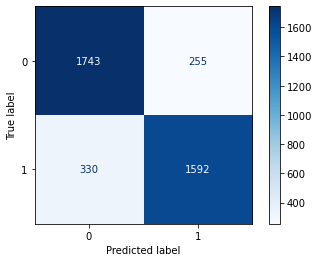

In [63]:
# Save confusion matrix values
tn1bii, fp1bii, fn1bii, tp1bii = confusion_matrix(y1_test, preds_tvec1bii).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_1bii, X1_test, y1_test, cmap='Blues', values_format='d');

### Model 2a - Using lemmatized text for Random Forest algorithm

In [64]:
X2 = combdf['lemmatized_selftext']
y2 = combdf['subreddit']

# Split data into train and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

##### (i) TF-IDF Vectorizer

In [65]:
pipeline2ai = Pipeline([
           ('vect', TfidfVectorizer()),
           ('rf', RandomForestClassifier()),
])

In [66]:
parameters2ai = [{
    'vect__max_features': [5_000, 10_000],
    'vect__stop_words': [None, 'english'],
    'vect__ngram_range': [(1,1), (1,2)],
    'rf__max_depth': [5,7],
    'rf__min_samples_split': [2,3]
}]

grid_search_2ai = GridSearchCV(pipeline2ai, parameters2ai, cv=3, verbose = 1)

In [67]:
grid_search_2ai.fit(X2_train, y2_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid=[{'rf__max_depth': [5, 7],
                          'rf__min_samples_split': [2, 3],
                          'vect__max_features': [5000, 10000],
                          'vect__ngram_range': [(1, 1), (1, 2)],
                          'vect__stop_words': [None, 'english']}],
             verbose=1)

In [68]:
grid_search_2ai.best_params_

{'rf__max_depth': 7,
 'rf__min_samples_split': 3,
 'vect__max_features': 10000,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': 'english'}

In [69]:
train_2ai = grid_search_2ai.score(X2_train, y2_train)
train_2ai

0.8676658163265306

In [70]:
test_2ai = grid_search_2ai.score(X2_test, y2_test)
test_2ai

0.8540816326530613

Comparing the training and testing score, the accuracy scores are quite similar. There are no signs of overfitting.

In [71]:
# Get predictions
preds_tvec2ai = grid_search_2ai.predict(X2_test)

# F1 score
f1_2ai = f1_score(y2_test,preds_tvec2ai)
f1_2ai

0.8619024625784645

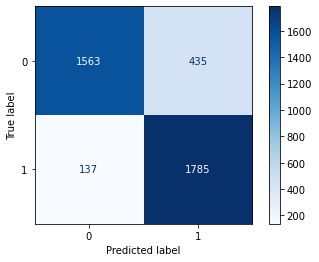

In [72]:
# Save confusion matrix values
tn2ai, fp2ai, fn2ai, tp2ai = confusion_matrix(y2_test, preds_tvec2ai).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_2ai, X2_test, y2_test, cmap='Blues', values_format='d');

##### (ii) Count Vectorizer

In [73]:
pipeline2aii = Pipeline([
           ('cvec', CountVectorizer()),
           ('rf', RandomForestClassifier()),
])

parameters2aii = [{
    'cvec__min_df': [0.05, 0.1],
    'cvec__max_df': [.9, .95],
    'cvec__max_features': [5_000, 10_000],
    'cvec__ngram_range': ((1, 1), (1, 2)),   
    'cvec__stop_words': [None, 'english'],
    'rf__max_depth': [5,7],
    'rf__min_samples_split': [2,3]
}]

grid_search_2aii = GridSearchCV(pipeline2aii, parameters2aii, cv=3, verbose = 1)

In [74]:
grid_search_2aii.fit(X2_train, y2_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid=[{'cvec__max_df': [0.9, 0.95],
                          'cvec__max_features': [5000, 10000],
                          'cvec__min_df': [0.05, 0.1],
                          'cvec__ngram_range': ((1, 1), (1, 2)),
                          'cvec__stop_words': [None, 'english'],
                          'rf__max_depth': [5, 7],
                          'rf__min_samples_split': [2, 3]}],
             verbose=1)

In [75]:
grid_search_2aii.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 0.05,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'rf__max_depth': 7,
 'rf__min_samples_split': 2}

In [76]:
train_2aii = grid_search_2aii.score(X2_train, y2_train)
train_2aii

0.8561224489795919

In [77]:
test_2aii = grid_search_2aii.score(X2_test, y2_test)
test_2aii

0.8433673469387755

Comparing the training and testing score, the accuracy scores are quite similar. There are no signs of overfitting.

In [78]:
# Get predictions
preds_tvec2aii = grid_search_2aii.predict(X2_test)

# F1 score
f1_2aii = f1_score(y2_test,preds_tvec2aii)
f1_2aii

0.8412616339193382

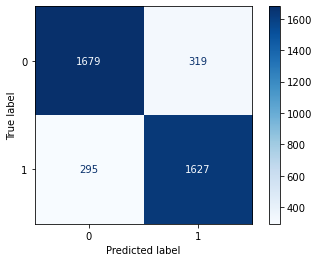

In [79]:
# Save confusion matrix values
tn2aii, fp2aii, fn2aii, tp2aii = confusion_matrix(y2_test, preds_tvec2aii).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_2aii, X2_test, y2_test, cmap='Blues', values_format='d');

### Model 2b - Using lemmatized text for Logistic Regression

##### (i) TF-IDF Vectorizer

In [80]:
pipeline2bi = Pipeline([
           ('vect', TfidfVectorizer()),
           ('lr', LogisticRegression()),
])

In [81]:
parameters2bi = [{
    'vect__max_features': [5_000, 10_000],
    'vect__stop_words': [None, 'english'],
    'vect__ngram_range': [(1,1), (1,2)],
    'lr__C': [10,1,0.1],
    'lr__penalty': ['l2','l1']
}]

grid_search_2bi = GridSearchCV(pipeline2bi, parameters2bi, cv=3, verbose = 1)

In [82]:
grid_search_2bi.fit(X2_train, y2_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid=[{'lr__C': [10, 1, 0.1], 'lr__penalty': ['l2', 'l1'],
                          'vect__max_features': [5000, 10000],
                          'vect__ngram_range': [(1, 1), (1, 2)],
                          'vect__stop_words': [None, 'english']}],
             verbose=1)

In [83]:
grid_search_2bi.best_params_

{'lr__C': 1,
 'lr__penalty': 'l2',
 'vect__max_features': 10000,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english'}

In [84]:
train_2bi = grid_search_2bi.score(X2_train, y2_train)
train_2bi

0.9430484693877551

In [85]:
test_2bi = grid_search_2bi.score(X2_test, y2_test)
test_2bi

0.8992346938775511

Even though the training score is quite high, but when comparing the training and testing score we can see that the model is overfitted.

In [86]:
# Get predictions
preds_tvec2bi = grid_search_2bi.predict(X2_test)

# F1 score
f1_2bi = f1_score(y2_test,preds_tvec2bi)
f1_2bi

0.8991575185090631

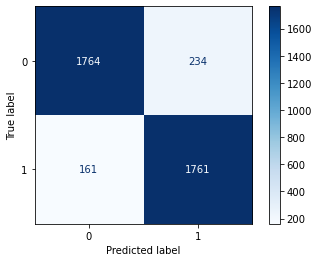

In [87]:
# Save confusion matrix values
tn2bi, fp2bi, fn2bi, tp2bi = confusion_matrix(y2_test, preds_tvec2bi).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_2bi, X2_test, y2_test, cmap='Blues', values_format='d');

##### (ii) CountVectorizer

In [88]:
pipeline2bii = Pipeline([
           ('cvec', CountVectorizer()),
           ('lr', LogisticRegression()),
])

parameters2bii = [{
    'cvec__min_df': [0.05, 0.1],
    'cvec__max_df': [.9, .95],
    'cvec__max_features': [5_000, 10_000],
    'cvec__ngram_range': ((1, 1), (1, 2)),   
    'cvec__stop_words': [None, 'english'],
    'lr__C': [10,1,0.1],
    'lr__penalty': ['l2','l1']
}]

grid_search_2bii = GridSearchCV(pipeline2bii, parameters2bii, cv=3, verbose = 1)

In [89]:
grid_search_2bii.fit(X2_train, y2_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid=[{'cvec__max_df': [0.9, 0.95],
                          'cvec__max_features': [5000, 10000],
                          'cvec__min_df': [0.05, 0.1],
                          'cvec__ngram_range': ((1, 1), (1, 2)),
                          'cvec__stop_words': [None, 'english'],
                          'lr__C': [10, 1, 0.1], 'lr__penalty': ['l2', 'l1']}],
             verbose=1)

In [90]:
grid_search_2bii.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 0.05,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'lr__C': 0.1,
 'lr__penalty': 'l2'}

In [91]:
train_2bii = grid_search_2bii.score(X2_train, y2_train)
train_2bii

0.8612882653061225

In [92]:
test_2bii = grid_search_2bii.score(X2_test, y2_test)
test_2bii

0.8507653061224489

Comparing the training and testing score, the accuracy scores are quite similar. There are no signs of overfitting.

In [93]:
# Get predictions
preds_tvec2bii = grid_search_2bii.predict(X2_test)

# F1 score
f1_2bii = f1_score(y2_test,preds_tvec2bii)
f1_2bii

0.8447864154948262

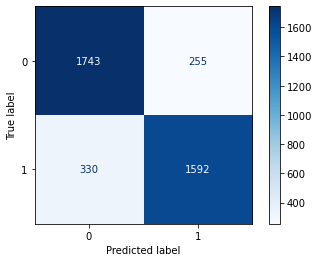

In [94]:
# Save confusion matrix values
tn2bii, fp2bii, fn2bii, tp2bii = confusion_matrix(y2_test, preds_tvec2bii).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_2bii, X2_test, y2_test, cmap='Blues', values_format='d');

### Model 3a - Using stemming text for Random Forest algorithm

In [95]:
X3 = combdf['stemming_selftext']
y3 = combdf['subreddit']

# Split data into train and test sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

##### (i) TF-IDF Vectorizer

In [96]:
pipeline3ai = Pipeline([
           ('vect', TfidfVectorizer()),
           ('rf', RandomForestClassifier()),
])

In [97]:
parameters3ai = [{
    'vect__max_features': [5_000, 10_000],
    'vect__stop_words': [None, 'english'],
    'vect__ngram_range': [(1,1), (1,2)],
    'rf__max_depth': [5,7],
    'rf__min_samples_split': [2,3]
}]

grid_search_3ai = GridSearchCV(pipeline3ai, parameters3ai, cv=3, verbose = 1)

In [98]:
grid_search_3ai.fit(X3_train, y3_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid=[{'rf__max_depth': [5, 7],
                          'rf__min_samples_split': [2, 3],
                          'vect__max_features': [5000, 10000],
                          'vect__ngram_range': [(1, 1), (1, 2)],
                          'vect__stop_words': [None, 'english']}],
             verbose=1)

In [99]:
grid_search_3ai.best_params_

{'rf__max_depth': 7,
 'rf__min_samples_split': 2,
 'vect__max_features': 10000,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': 'english'}

In [100]:
train_3ai = grid_search_3ai.score(X3_train, y3_train)
train_3ai

0.8673469387755102

In [101]:
test_3ai = grid_search_3ai.score(X3_test, y3_test)
test_3ai

0.8482142857142857

Comparing the training and testing score, the accuracy scores are quite similar. There are no signs of overfitting.

In [102]:
# Get predictions
preds_tvec3ai = grid_search_3ai.predict(X3_test)

# F1 score
f1_3ai = f1_score(y3_test,preds_tvec3ai)
f1_3ai

0.846925649601235

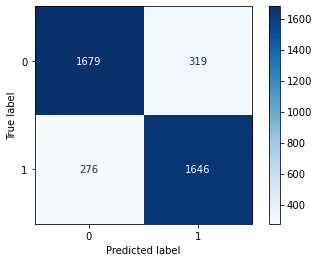

In [103]:
# Save confusion matrix values
tn3ai, fp3ai, fn3ai, tp3ai = confusion_matrix(y3_test, preds_tvec3ai).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_3ai, X3_test, y3_test, cmap='Blues', values_format='d');

##### (ii) Count Vectorizer

In [104]:
pipeline3aii = Pipeline([
           ('cvec', CountVectorizer()),
           ('rf', RandomForestClassifier()),
])

parameters3aii = [{
    'cvec__min_df': [0.05, 0.1],
    'cvec__max_df': [.9, .95],
    'cvec__max_features': [5_000, 10_000],
    'cvec__ngram_range': ((1, 1), (1, 2)),   
    'cvec__stop_words': [None, 'english'],
    'rf__max_depth': [5,7],
    'rf__min_samples_split': [2,3]
}]

grid_search_3aii = GridSearchCV(pipeline3aii, parameters3aii, cv=3, verbose = 1)

In [105]:
grid_search_3aii.fit(X3_train, y3_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid=[{'cvec__max_df': [0.9, 0.95],
                          'cvec__max_features': [5000, 10000],
                          'cvec__min_df': [0.05, 0.1],
                          'cvec__ngram_range': ((1, 1), (1, 2)),
                          'cvec__stop_words': [None, 'english'],
                          'rf__max_depth': [5, 7],
                          'rf__min_samples_split': [2, 3]}],
             verbose=1)

In [106]:
grid_search_3aii.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 10000,
 'cvec__min_df': 0.05,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'rf__max_depth': 7,
 'rf__min_samples_split': 2}

In [107]:
train_3aii = grid_search_3aii.score(X3_train, y3_train)
train_3aii

0.8588010204081633

In [108]:
test_3aii = grid_search_3aii.score(X3_test, y3_test)
test_3aii

0.8408163265306122

Comparing the training and testing score, the accuracy scores are quite similar. There are no signs of overfitting.

In [109]:
# Get predictions
preds_tvec3aii = grid_search_3aii.predict(X3_test)

# F1 score
f1_3aii = f1_score(y3_test,preds_tvec3aii)
f1_3aii

0.8401639344262295

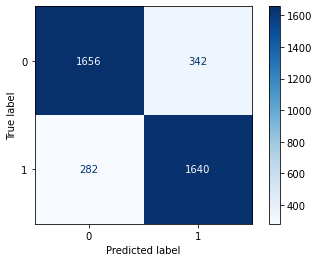

In [110]:
# Save confusion matrix values
tn3aii, fp3aii, fn3aii, tp3aii = confusion_matrix(y3_test, preds_tvec3aii).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_3aii, X3_test, y3_test, cmap='Blues', values_format='d');

### Model 3b - Using stemming text for Logistic Regression

##### (i) TF-IDF Vectorizer

In [111]:
pipeline3bi = Pipeline([
           ('vect', TfidfVectorizer()),
           ('lr', LogisticRegression()),
])

In [112]:
parameters3bi = [{
    'vect__max_features': [5_000, 10_000],
    'vect__stop_words': [None, 'english'],
    'vect__ngram_range': [(1,1), (1,2)],
    'lr__C': [10,1,0.1],
    'lr__penalty': ['l2','l1']
}]

grid_search_3bi = GridSearchCV(pipeline3bi, parameters3bi, cv=3, verbose = 1)

In [113]:
grid_search_3bi.fit(X3_train, y3_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid=[{'lr__C': [10, 1, 0.1], 'lr__penalty': ['l2', 'l1'],
                          'vect__max_features': [5000, 10000],
                          'vect__ngram_range': [(1, 1), (1, 2)],
                          'vect__stop_words': [None, 'english']}],
             verbose=1)

In [114]:
grid_search_3bi.best_params_

{'lr__C': 1,
 'lr__penalty': 'l2',
 'vect__max_features': 10000,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english'}

In [115]:
train_3bi = grid_search_3bi.score(X3_train, y3_train)
train_3bi

0.9430484693877551

In [116]:
test_3bi = grid_search_3bi.score(X3_test, y3_test)
test_3bi

0.8992346938775511

Even though the training score is quite high, but when comparing the training and testing score we can see that the model is overfitted.

In [117]:
# Get predictions
preds_tvec3bi = grid_search_3bi.predict(X3_test)

# F1 score
f1_3bi = f1_score(y3_test,preds_tvec3bi)
f1_3bi

0.8991575185090631

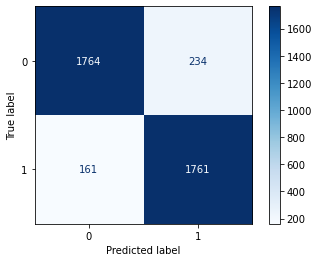

In [118]:
# Save confusion matrix values
tn3bi, fp3bi, fn3bi, tp3bi = confusion_matrix(y3_test, preds_tvec3bi).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_3bi, X3_test, y3_test, cmap='Blues', values_format='d');

##### (ii) CountVectorizer

In [119]:
pipeline3bii = Pipeline([
           ('cvec', CountVectorizer()),
           ('lr', LogisticRegression()),
])

parameters3bii = [{
    'cvec__min_df': [0.05, 0.1],
    'cvec__max_df': [.9, .95],
    'cvec__max_features': [5_000, 10_000],
    'cvec__ngram_range': ((1, 1), (1, 2)),   
    'cvec__stop_words': [None, 'english'],
    'lr__C': [10,1,0.1],
    'lr__penalty': ['l2','l1']
}]

grid_search_3bii = GridSearchCV(pipeline3bii, parameters3bii, cv=3, verbose = 1)

In [120]:
grid_search_3bii.fit(X3_train, y3_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid=[{'cvec__max_df': [0.9, 0.95],
                          'cvec__max_features': [5000, 10000],
                          'cvec__min_df': [0.05, 0.1],
                          'cvec__ngram_range': ((1, 1), (1, 2)),
                          'cvec__stop_words': [None, 'english'],
                          'lr__C': [10, 1, 0.1], 'lr__penalty': ['l2', 'l1']}],
             verbose=1)

In [121]:
grid_search_3bii.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 0.05,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'lr__C': 0.1,
 'lr__penalty': 'l2'}

In [122]:
train_3bii = grid_search_3bii.score(X3_train, y3_train)
train_3bii

0.8612882653061225

In [123]:
test_3bii = grid_search_3bii.score(X3_test, y3_test)
test_3bii

0.8507653061224489

Comparing the training and testing score, the accuracy scores are quite similar. There are no signs of overfitting.

In [124]:
# Get predictions
preds_tvec3bii = grid_search_3bii.predict(X3_test)

# F1 score
f1_3bii = f1_score(y3_test,preds_tvec3bii)
f1_3bii

0.8447864154948262

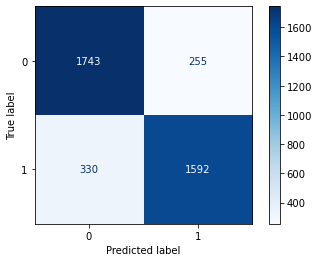

In [125]:
# Save confusion matrix values
tn3bii, fp3bii, fn3bii, tp3bii = confusion_matrix(y3_test, preds_tvec3bii).ravel()

# Plot confusion matrix
plot_confusion_matrix(grid_search_3bii, X3_test, y3_test, cmap='Blues', values_format='d');

## Evaluation

In addition to the training and testing accuracy score (to look for overfitted models), we will be looking at the F1 score here as well since we are a neutral company, and we seek to minimise both the false negatives (classified as disneyplus even though they should be classified as netflix) and the false positives (classified as netflix even though they should be classified as disneyplus). We seek to optimise the F1 score, which will give us the harmonic mean of precision and recall scores. 

In [126]:
# Putall the training, testing and F1 score together to compare the various models

dictionary = {
    'Model': ['1ai','1aii','1bi','1bii','2ai','2aii','2bi','2bii','3ai','3aii','3bi','3bii'],
    'Training Score': [train_1ai,train_1aii,train_1bi,train_1bii,train_2ai,train_2aii,train_2bi,train_2bii,
                       train_3ai,train_3aii,train_3bi,train_3bii],
    'Testing Score': [test_1ai,test_1aii,test_1bi,test_1bii,test_2ai,test_2aii,test_2bi,test_2bii,
                       test_3ai,test_3aii,test_3bi,test_3bii],
    'F1 Score': [f1_1ai,f1_1aii,f1_1bi,f1_1bii,f1_2ai,f1_2aii,f1_2bi,f1_2bii,
                    f1_3ai,f1_3aii,f1_3bi,f1_3bii]
}

df_score = pd.DataFrame(dictionary)
df_score.sort_values('F1 Score', ascending = False)

,Model,Training Score,Testing Score,F1 Score
2,1bi,0.943048,0.899235,0.899158
6,2bi,0.943048,0.899235,0.899158
10,3bi,0.943048,0.899235,0.899158
0,1ai,0.860969,0.852806,0.862652
4,2ai,0.867666,0.854082,0.861902
8,3ai,0.867347,0.848214,0.846926
3,1bii,0.861288,0.850765,0.844786
7,2bii,0.861288,0.850765,0.844786
11,3bii,0.861288,0.850765,0.844786
5,2aii,0.856122,0.843367,0.841262


All the models perform better compared to the baseline model (50% accuracy). However, model 1bi, 2bi and 3bi are overfitted as their training score is way higher than their testing score.

As for the remaining models, model 1ai, 2ai and 3ai has the best F1 score and the best training/testing score. Among these 3 models, there are not much difference, but if we have to pick the best model, we will choose model 1ai as the difference between the training and testing score is the least.

<b> Model 1ai - Random Forest algorithm using TF-IDF vectoriser with selftext is the best performing model </b>.

We will be using this model to classify our tv/movie into the two platform using the tv/movie reviews.

These are the parameters that gave us the best random forest algorithm using TF-IDF vectoriser with lemmatised text

In [131]:
grid_search_1ai.best_params_

{'rf__max_depth': 7,
 'rf__min_samples_split': 2,
 'vect__max_features': 5000,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': 'english'}

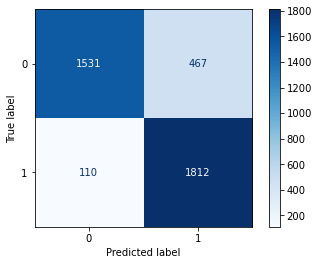

In [132]:
plot_confusion_matrix(grid_search_1ai, X1_test, y1_test, cmap='Blues', values_format='d');

We have to keep in mind that there are more false positives (467) than false negatives (110), i.e. more instances of the model classifying the texts as Netflix even though they should be DisneyPlus, when using the model. 

In [135]:
pipeline1ai.fit(X1_train, y1_train)

Pipeline(steps=[('vect', TfidfVectorizer()), ('rf', RandomForestClassifier())])

In [136]:
# The top 20 most important words that our model used to make its predictions
df_words = pd.DataFrame(pipeline1ai.steps[1][1].feature_importances_, pipeline1ai.steps[0][1].get_feature_names(), columns=['importance'])
df_words.sort_values('importance', ascending = False).head(20)

,importance
disney,0.052049
netflix,0.047973
plus,0.014836
and,0.007692
the,0.007016
show,0.006789
of,0.006607
to,0.005878
that,0.005848
it,0.005758


## Conclusions and Recommendations

**Conclusion:**

From the top 20 words, other than the top 3 words: 'disney', 'netflix' and 'plus', which probably relates to disneyplus, netflix and disneyplus respectively, the remaining words seem to be quite generic. 

The top 2 words is also ~4-5x more important than the 3rd/4th words. 

This tells us that if our movie reviews do not have 'disney' or 'netflix' in them (which is highly likely since our shows are not on either platforms yet), our model may possibly have a hard time classifying the reviews. This would possibly impact the accuracy of our model. 

**Recommendations:**

Improvement to the model could be made by: 
- Removing words with high correlation to the subreddits such as 'disney', 'netflix', 'plus'
- Adjusting the weights of 'disney', 'netflix' and 'plus'
